<a href="https://colab.research.google.com/github/Pari-singh/AmazonBeautyProduct_RecommenderSystem/blob/master/Text_Embeddings_and_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification of Review Summary

Estimated Time taken : 5 hrs (Mostly in (re)training the model for accuracy )

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


### Importing libraries and zipfiles

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import pandas as pd
import gzip
import nltk, re
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
#!wget http://nlp.stanford.edu/data/glove.6B.zip

import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall("glove.6B")
zip_ref.close()

from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading data into dataframe

In [8]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

ratings = getDF('reviews_Beauty_5.json.gz')
ratings.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)

ratings['user_emb_id'] = ratings.user_id.astype('category').cat.codes.values
ratings['item_emb_id'] = ratings.item_id.astype('category').cat.codes.values
ratings.sample(7)

,user_id,item_id,user_name,helpful,review_text,score,review_summary,unixReviewTime,reviewTime,user_emb_id,item_emb_id
12972,A2PAQWQIHIB30T,B0009MHJS0,"Nefertiti ""Lynnette Burton""","[2, 2]",I love the shea butter 100% pure & raw. It wor...,5.0,Great Product!,1332460800,"03 23, 2012",10106,770
161005,A3R3VZ1GEYMLMI,B009CS493U,Jackie,"[0, 0]",Its like a fake gold necklace making those des...,3.0,its ok,1397088000,"04 10, 2014",16314,10353
41264,A2LBN99KCBHEDR,B00128WK4I,Jenn,"[17, 22]",I started using this product about 3 months ag...,4.0,Great Product! Buy it somewhere else though.,1346803200,"09 5, 2012",9393,2780
79947,AMUKWN4BTOGAJ,B002VH64KA,Andy Hdz,"[0, 0]",My dermatologist recommended this product for ...,5.0,GREAT FOR EVERYDAY,1358294400,"01 16, 2013",20268,5377
170020,A1ZZZT0KJR46UV,B00AE07EIM,Darla Mcgranaghan,"[0, 2]",A really nice product that leaves the hair and...,5.0,A+ all the way,1363824000,"03 21, 2013",5842,10702
180353,A3UMD2J83ORKUF,B00CF7HBA8,CR,"[1, 1]",I'm providing this review of the Croc Hair Sty...,4.0,Clips are fantastic!,1393891200,"03 4, 2014",16928,11261
149738,A103979529MRJY0U56QI4,B007TKL5UI,liquidbabydoll,"[0, 1]",these really look like hello kitty and clear g...,5.0,i love em,1375660800,"08 5, 2013",47,9619


In [20]:
ratings['score'].isnull().any()

False

In [0]:
labels = ratings['score'].map(lambda x : 1 if int(x) > 3 else 0)

### Preprocessing the Review Summary from the data before Classifying

In [0]:
def preprocess_text(text, chop):
  '''
    input -  text: string object containing the review
             chop: testing stemming/lemmatization
             
    output - returns preprocessed text back
  '''

  #   print("reached the first line")
  a = list(string.punctuation)
  a.remove("'")
  b = "".join(a)
  text = text.translate(str.maketrans('', '', b))   ## Removes punctuations
  
  text = text.lower().split() ## Converts to lower case and into a list
  text = " ".join(text)
  
  
## Some manual cleaning required! 
  
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r" e g ", " eg ", text)
  text = re.sub(r" b g ", " bg ", text)
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
  text = re.sub(r"[^A-Za-z]", " ", text)
  
  
  ## removing context based stop words rather than using nltk stop words for preserving the sentiment-depicting words like not etc.
  stops = ['i','me','my','myself','we','our','ours','ourselves','you',"youre","youve","youll","youd",'your',\
           'yours','yourself','yourselves','he','him','his','himself','she',"shes",'her','hers','herself','it','its','itself',\
           'they','them','their','theirs','themselves','what','which','who','whom','this','that',"thatll",'these','those','am',\
           'is','are','was','were','be','been','being','do','does','did','doing','a','an','the','and','if','or','because','as',\
           'until','while','of','at','by','for','with','about','against','between','into','through','during','before','after',\
           'above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here', 'only', \
           'there','when','where','why','how','so','will','would','just', 'hey', 'hi', 'though', 'and', 'yet', 'but', 'nonetheless', 'thus', 'therefore']
  
  
  text = [w for w in text.split() if w not in stops]
  
  text = " ".join(text)
  
  text = text.split()
  if chop == 'Stem':
    ## Stemming
    stemmer = SnowballStemmer('english')
    chopped_words = [stemmer.stem(word) for word in text]
    
  if chop == "lemmatize":
    lemmatizer = nltk.stem.WordNetLemmatizer()
    chopped_words = [lemmatizer.lemmatize(word) for word in text]
    
  text = " ".join(chopped_words)  
  
  return text


ratings['review_summary'] = ratings['review_summary'].map(lambda x: preprocess_text(x, 'lemmatize'))

### Creating the Word Embedding
Tried spacy many times, was taking too long to run even the pre-trained model. Thus decided on tokenizing directly from the GLoVe dictionary

In [0]:
embeddings_index = dict()
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


tokenizer = Tokenizer()
tokenizer.fit_on_texts(ratings['review_summary'])
vocabulary_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(ratings['review_summary'])
padded_doc = pad_sequences(sequences, maxlen=50)

embedding_matrix = np.zeros((vocabulary_size, 100))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


In [0]:
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(padded_doc, labels, test_size=.2, random_state=7)

### MultinomialNB (Creating Baseline)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits= 10, random_state=8)
a = skf.split(X_train, np.array(y_train))

F1 = []
matrix = []
for t_d, te_d in a:
    model_base = LinearSVC(C=0.5, class_weight={0:1, 1:10})
    model_base.fit(X_train[t_d], np.array(y_train)[t_d])
    predictions = model_base.predict(X_train[te_d])
    predictions = predictions.reshape(-1)
    y_pred = [1 if(i > 0.5) else 0 for i in predictions]
    base_matrix = metrics.confusion_matrix(np.array(y_train)[te_d], y_pred)
    tn, fp, fn, tp =  base_matrix.ravel()
    base_sensitivity = tp * 1.0 / (tp + fn) * 1.0  
    base_Precision = tp*1.0 / (tp+fp) *1.0  
    base_f1 = 2* ((base_Precision*base_sensitivity)/(base_Precision+base_sensitivity)) 
    base_sensitivity, base_Precision, base_f1
    matrix.append(base_matrix)
    F1.append(base_f1)
    
    
# def get_info(model,data, target_variable, prim_var,train_index, test_index, ngram_range):
#   clf = MultinomialNB()
#   clf.fit(X_train, np.array(y_train))

In [28]:
max(F1), F1

(0.8682398508105005,
 [0.8633332131655791,
  0.8682398508105005,
  0.7223268649524728,
  0.8589327991258423,
  0.7807043012982704,
  0.8325590179414541,
  0.8328609757019234,
  0.7808207911834855,
  0.6341774636827641,
  0.8548887833741189])

We see the best F1 score is on the 2nd run of K-fold giving us the F1 score of 86.82%

In [31]:
base_matrix = matrix[1]
# base_matrix = metrics.confusion_matrix(np.array(y_test), y_pred)
tn, fp, fn, tp =  base_matrix.ravel()
base_sensitivity = tp * 1.0 / (tp + fn) * 1.0  
base_Precision = tp*1.0 / (tp+fp) *1.0  
base_f1 = 2* ((base_Precision*base_sensitivity)/(base_Precision+base_sensitivity)) 
base_sensitivity, base_Precision, base_f1

(0.980082584406121, 0.7793085688534088, 0.8682398508105005)

### Building LSTM Classifier

In [0]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, 100, weights=[embedding_matrix], input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model_lstm.fit(X_train, np.array(y_train), validation_split=0.2, epochs=5)

Train on 127040 samples, validate on 31761 samples
Epoch 1/5
127040/127040 [==============================] - 586s 5ms/step - loss: 0.2086 - acc: 0.9203 - val_loss: 0.2828 - val_acc: 0.8912
Epoch 2/5
127040/127040 [==============================] - 587s 5ms/step - loss: 0.1956 - acc: 0.9249 - val_loss: 0.2891 - val_acc: 0.8912
Epoch 3/5
127040/127040 [==============================] - 579s 5ms/step - loss: 0.1838 - acc: 0.9300 - val_loss: 0.3019 - val_acc: 0.8875
Epoch 4/5
127040/127040 [==============================] - 598s 5ms/step - loss: 0.1745 - acc: 0.9344 - val_loss: 0.3171 - val_acc: 0.8878
Epoch 5/5
127040/127040 [==============================] - 597s 5ms/step - loss: 0.1656 - acc: 0.9373 - val_loss: 0.3235 - val_acc: 0.8866


In [41]:
predictions = model_lstm.predict(X_test)
predictions = predictions.reshape(-1)
y_pred = [1 if(i > 0.5) else 0 for i in predictions]

matrix = metrics.confusion_matrix(np.array(y_test), y_pred)
tn, fp, fn, tp =  matrix.ravel()
sensitivity = tp * 1.0 / (tp + fn) * 1.0  
Precision = tp*1.0 / (tp+fp) *1.0  
f1 = 2* ((Precision*sensitivity)/(Precision+sensitivity))  
sensitivity, Precision, f1

(0.9349868348340539, 0.9173337585712008, 0.9260761775974757)

We observe the accuracy of the  model around 88.66% on validation set. However, Accuracy generally is not the best metric to look for, especially in classification of texts cases. As there can be cases where our data is biased to one of the classes and in that case even if the model is something which predicts just one output no matter of the input, we can achieve very high accuaracy. That would be disastrous. Thus we always look for Sensitivity (Recall) and Precision of our model, which says out of all the positives the model has predicted, how many are infact true, and out of the actual true cases, how many could my model predict  to be true respectively. Combining these two important scores is the F1 score and thus F1 forms to be the reliable metric to decide upon our classifier.

In [0]:
from keras.models import load_model
model_lstm.save('LSTM_model.h5')

## Visualising word embeddings

Visualizing randomly chosen 100 word vectors on feature space

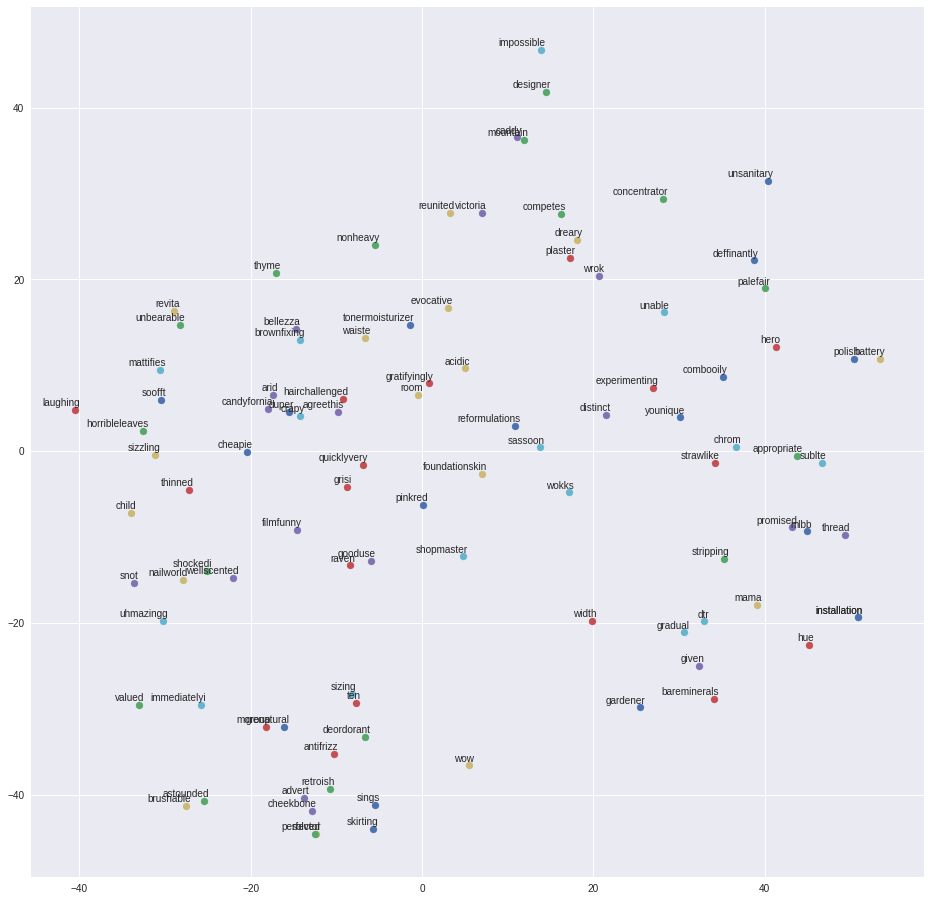

In [42]:
import random
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(embedding_matrix)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for j in range(100):
  i = random.randint(1,len(x))
  plt.scatter(x[i],y[i])
  plt.annotate(list(tokenizer.word_index.keys())[i],
               xy=(x[i], y[i]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.show()
